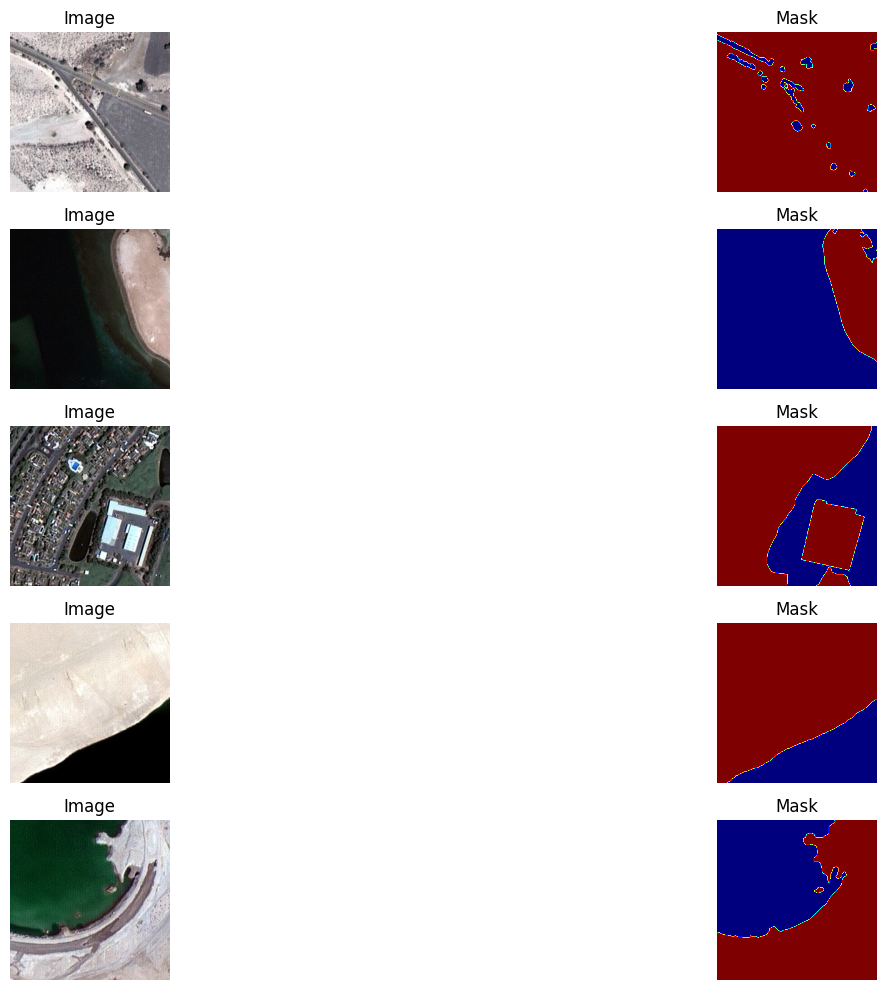

In [64]:
import random
import matplotlib.pyplot as plt

def display_samples(images, masks, num_samples=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title('Image')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(masks[idx].argmax(axis=-1), cmap='jet')  # Assuming masks are in one-hot encoding
        plt.axis('off')
        plt.title('Mask')
    plt.tight_layout()
    plt.show()

display_samples(image_dataset, mask_dataset)


In [2]:
import warnings
import json
warnings.filterwarnings("ignore")

In [ ]:
!pip install fastai

In [3]:
#importing libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [4]:
# Replace with correct kaggle credentials
kaggle_credentials = {
    "username": "tarekziad",
    "key": "40b30aa49d333ec3eeafe32b7584f421"
}

# Write the new kaggle.json file
with open('kaggle.json', 'w') as file:
    json.dump(kaggle_credentials, file)

print("kaggle.json created successfully.")

kaggle.json created successfully.


In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery
!unzip semantic-segmentation-of-aerial-imagery.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
License(s): CC0-1.0
 61% 18.0M/29.6M [00:00<00:00, 177MB/s]
100% 29.6M/29.6M [00:00<00:00, 196MB/s]


In [7]:
import zipfile

with zipfile.ZipFile('/content/semantic-segmentation-of-aerial-imagery.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [8]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# List TPUs available
tpus = tf.config.list_physical_devices('TPU')
print("TPUs:", tpus)

# Check if TPUs are available
if tpus:
    print("TPU is available.")
else:
    print("TPU is not available.")

# Set up TPU strategy
if tpus:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Automatically detect TPU in Colab
    tf.config.experimental_connect_to_cluster(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Using TPU Strategy:", strategy)
else:
    print("No TPU detected. Ensure TPU runtime is enabled.")


TensorFlow version: 2.15.0
TPUs: [PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]
TPU is available.
Using TPU Strategy: <tensorflow.python.distribute.tpu_strategy.TPUStrategyV2 object at 0x7a27ea235f00>


In [ ]:


import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# List GPUs available
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Check if GPUs are available
if gpus:
    print("GPU is available.")
else:
    print("GPU is not available.")

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)



In [9]:
!pip install matplotlib > /dev/null
!pip install scikit-learn > /dev/null
!pip install -U segmentation-models > /dev/null
!pip install patchify > /dev/null
!pip install Pillow > /dev/null


**Patchify images and masks**

In [10]:
import os
import cv2
import numpy as np

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `tf.keras` framework.


In [11]:
root_directory = "/content/data/Semantic segmentation dataset"

scaler = MinMaxScaler()
patch_size = 256

In [12]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):   #Only read jpg images

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        image_dataset.append(single_patch_img)

Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_001.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_002.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_003.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_004.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_005.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_006.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_007.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_008.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_009.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 7/images/image_part_001.jpg


In [13]:
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images

                mask = cv2.imread(path+"/"+mask_name, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                mask = np.array(mask)

                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_001.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_002.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_003.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_004.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_005.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_006.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_007.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_008.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_009.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 7/masks/image_part_001.png
Now patchifying mask

In [14]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [15]:
print("Number of images in dataset:", len(image_dataset))
print("Number of masks in dataset:", len(mask_dataset))

Number of images in dataset: 1305
Number of masks in dataset: 1305


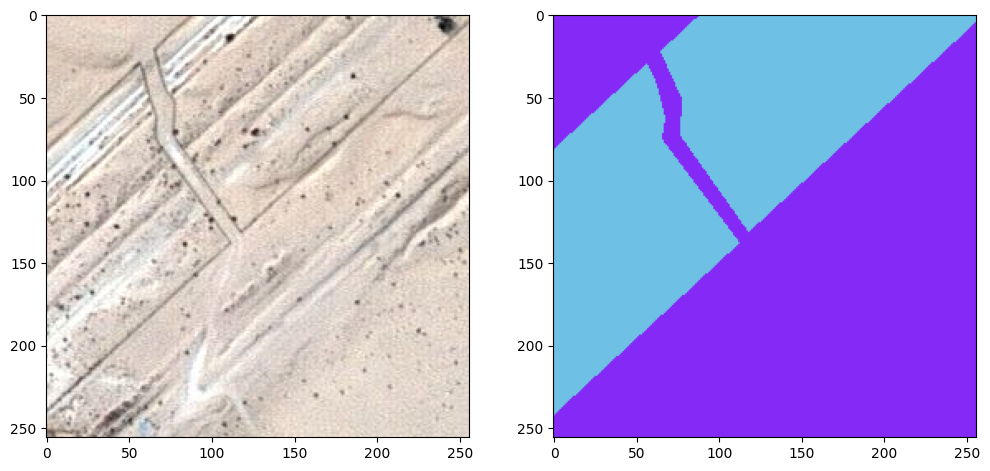

In [16]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [17]:
#Convert HEX to RGB array

a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

60


In [18]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]

    return label_seg

In [19]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


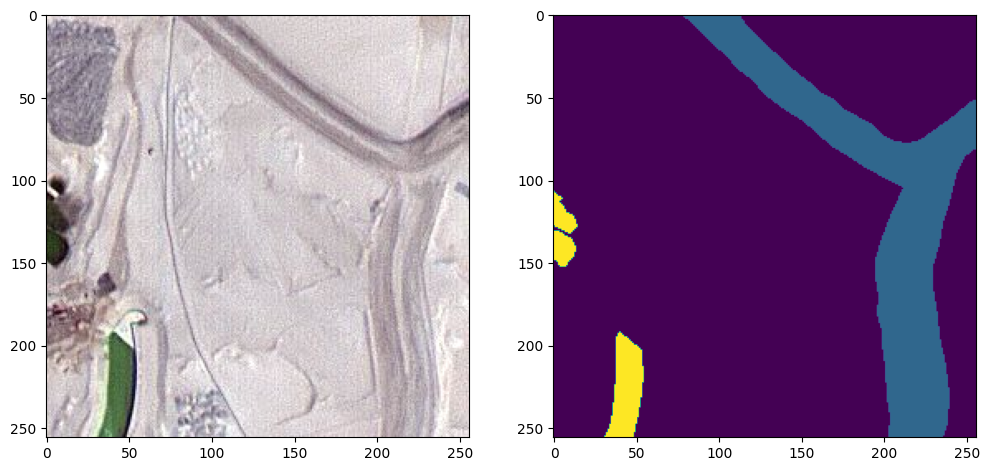

In [20]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [21]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K



In [22]:
def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

## **Build the U-Net model**

In [23]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

**Train U-Net model with the preprocessed dataset**

In [ ]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    shuffle=False)

**Save trained model to Kaggle Output**

In [ ]:
path_model = '/content/data/working/satellite_standard_unet_100epochs.hdf5'
model.save(path_model)

**Plot training and validation accuracy and loss at each epoch**

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

**Predict Using Saved Model**

In [ ]:
import tensorflow as tf

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow.keras.models import load_model
import segmentation_models as sm
from tensorflow.keras import backend as K

# Define the custom loss functions
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  # Composite loss function

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



In [30]:
# Path to your model
model_path = path_model

In [ ]:
custom_objects = {
    "dice_loss_plus_1focal_loss": total_loss,
    "jacard_coef": jacard_coef
}

# Load the model with custom objects
model = load_model(model_path, custom_objects=custom_objects)

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [ ]:
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

```
Benchmarking:

    Excellent: Mean IoU > 0.8
    Good: 0.6 < Mean IoU ≤ 0.8
    Moderate: 0.4 < Mean IoU ≤ 0.6
    Poor: Mean IoU ≤ 0.4

```

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
# Number of images to predict
num_images = 5

# Plot setup
plt.figure(figsize=(20, 20))

for i in range(num_images):
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img)
    plt.show()

```
Dice Coefficient (Dice Score)

    Purpose: Measures the overlap between predicted and true segmentation masks.
```

```
Precision and Recall

    Purpose: Precision measures how many predicted positive cases are true positives. Recall measures how many true positive cases are captured by the model.
```

```
Hausdorff Distance

    Purpose: Measures the distance between the boundaries of predicted and true segmentation masks.
```

In [ ]:
import tensorflow as tf
from keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score

# Define number of classes
n_classes = 6

# IoU Metric
iou_keras = MeanIoU(num_classes=n_classes)
iou_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", iou_keras.result().numpy())


import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Convert to one-hot encoding if not already (assuming y_true, y_pred are integer class labels)
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)
    y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=n_classes)

    # Flatten the one-hot encoded tensors for each class
    y_true_flat = tf.reshape(y_true_one_hot, [-1, n_classes])
    y_pred_flat = tf.reshape(y_pred_one_hot, [-1, n_classes])

    # Compute Dice Coefficient per class and then average
    intersection = tf.reduce_sum(tf.cast(y_true_flat * y_pred_flat, tf.float32), axis=0)
    union = tf.reduce_sum(tf.cast(y_true_flat, tf.float32), axis=0) + tf.reduce_sum(tf.cast(y_pred_flat, tf.float32), axis=0)

    dice_per_class = (2. * intersection + smooth) / (union + smooth)
    dice_mean = tf.reduce_mean(dice_per_class)  # Average Dice coefficient across all classes

    return dice_mean

# Example usage
dice = dice_coefficient(y_test_argmax, y_pred_argmax)
print("Dice Coefficient =", dice.numpy())


# Precision and Recall
precision = precision_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted', zero_division=1)
recall = recall_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted', zero_division=1)
print("Precision =", precision)
print("Recall =", recall)

# F1 Score
f1 = f1_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted')
print("F1 Score =", f1)


import tensorflow as tf

def pixel_accuracy(y_true, y_pred):
    # Ensure both tensors are of the same type, here they're int64
    y_true = tf.cast(y_true, tf.int64)  # Make sure both are int64
    y_pred = tf.cast(y_pred, tf.int64)

    # Compute accuracy
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total = tf.size(y_true, out_type=tf.float32)  # Make sure the size is float for division
    return correct / total

# Example usage
accuracy = pixel_accuracy(y_test_argmax, y_pred_argmax)
print("Pixel Accuracy =", accuracy.numpy())




```

Mean IoU (0.5989): Fairly decent, indicating that the model is capturing a good portion of the overlap between predictions and ground truth.
Dice Coefficient (0.6941): Solid score, shows good segmentation ability.
Precision (0.8680) and Recall (0.8691): Both high, meaning the model is accurate and captures most relevant instances.
F1 Score (0.8676): Strong balance between precision and recall.
Pixel Accuracy (0.8691): Good accuracy in pixel-wise predictions.
```

In [ ]:
print("Data type of y_test_argmax:", y_test_argmax.dtype)
print("Data type of y_pred_argmax:", y_pred_argmax.dtype)


# **Bayesian Markov Random Fields (MRF)**

---



In [24]:
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Layer
from keras.models import Model
from keras import backend as K
import segmentation_models as sm  # Ensure segmentation_models is installed

# Define the custom loss functions
weights = [0.1666] * 6
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss  # Composite loss function

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def full_bayesian_mrf_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Define MRF_layer
    class MRF_layer(Layer):
        def __init__(self, n_classes, **kwargs):
            self.n_classes = n_classes
            super(MRF_layer, self).__init__(**kwargs)

        def build(self, input_shape):
            self.kernel = self.add_weight(name='kernel',
                                          shape=(1, 1, input_shape[-1], self.n_classes),
                                          initializer='uniform',
                                          trainable=True)
            super(MRF_layer, self).build(input_shape)

        def call(self, x):
            return K.conv2d(x, self.kernel, strides=(1, 1), padding='same')

    # Applying MRF Layer
    mrf_layer = MRF_layer(n_classes=n_classes)(c9)

    # Final output
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(mrf_layer)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define metrics
metrics = ['accuracy', jacard_coef]

def get_model():
    return full_bayesian_mrf_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

# Compile the model
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

```
Original Model (Multi-UNet)

    Standard U-Net Architecture:
        A contracting path (downsampling) with several convolutional layers followed by max-pooling to reduce spatial resolution.
        An expansive path (upsampling) with transposed convolutions and concatenations to recover spatial resolution and merge lower-level features with higher-level representations.
        Output Layer: A Conv2D layer with n_classes filters and a softmax activation function for multi-class segmentation.

Changes in the New Model (Full Bayesian MRF Model)

You retained most of the structure of the U-Net but added a Bayesian Markov Random Field (MRF) layer, which is designed to better capture the spatial dependencies in the segmentation task.
1. Contraction and Expansive Paths:

    The contraction path with convolutions, ReLU activations, dropouts, and max-pooling layers remains the same. These layers reduce the resolution of the input image while capturing rich feature representations.
    The expansive path (upsampling) also remains similar to the original model, using transpose convolutions and concatenating with earlier layers' feature maps.

2. Adding a Custom MRF Layer:

    You introduced an MRF (Markov Random Field) layer, which is a custom layer intended to capture spatial dependencies between pixels, potentially improving the segmentation accuracy by smoothing the predicted labels spatially.
    Custom MRF Layer Implementation:
        You defined the MRF layer as a subclass of Layer in Keras.
        The MRF_layer class initializes a convolution kernel that learns the spatial relationships between pixels in the feature maps.
        The call method applies the kernel as a convolution operation on the input feature maps, with strides of (1, 1) and 'same' padding to preserve the spatial dimensions.
        This layer serves as an intermediate step between the U-Net layers and the final output layer, adding Bayesian probabilistic modeling to predict smoother and spatially dependent segmentation masks.

3. Modifications to the Output:

    After passing the output of the final convolutional layer (c9) through the MRF layer, the resulting feature maps are fed into a Conv2D layer with softmax activation, which produces the final multi-class segmentation output.
    The idea here is that the MRF layer helps refine the output by considering the relationships between neighboring pixels, thereby encouraging more coherent segmentations.

4. Compilation:

    You retained the metrics ['accuracy', 'jacard_coef'], which measure segmentation performance.
    You still use the Adam optimizer and your custom loss function (total_loss), which could be a combination of losses, potentially including cross-entropy and other loss terms that take into account the MRF layer's spatial consistency.

Explanation of Markov Random Field (MRF) Layer in Segmentation

    Markov Random Fields (MRF): MRFs are a type of probabilistic graphical model that captures dependencies between neighboring pixels in an image. In semantic segmentation, the MRF layer models the relationships between adjacent pixel labels, encouraging spatial consistency in the output (i.e., neighboring pixels should have similar labels if they belong to the same object or region).

    Bayesian MRF: This approach extends traditional MRFs by incorporating Bayesian inference, allowing the model to estimate the probability distribution of pixel labels based on both local and global image information. It can improve segmentation accuracy by reducing noisy or isolated misclassifications, resulting in smoother segmentations.

Key Advantages of Adding MRF to the Model:

    Smoother Segmentations: The MRF layer enforces spatial dependencies, encouraging neighboring pixels to have similar labels, which can lead to more coherent segmentation results.
    Reduced Noise: By modeling spatial relationships, the MRF layer can reduce noise in segmentation, where isolated misclassifications might otherwise occur.
    Improved Accuracy: The combination of the U-Net's feature extraction capabilities and the MRF's spatial modeling can lead to improved segmentation accuracy, especially in tasks where fine spatial details are important.

The MRF layer improves the segmentation by considering spatial dependencies between neighboring pixels, which can be especially useful for semantic segmentation tasks that require precise boundaries and coherence in the predicted output.
```

In [25]:
history5 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/30
66/66 [==============================] - 117s 2s/step - loss: 1.0004 - accuracy: 0.5237 - jacard_coef: 0.2532 - val_loss: 0.9933 - val_accuracy: 0.5520 - val_jacard_coef: 0.3217
Epoch 2/30
66/66 [==============================] - 109s 2s/step - loss: 0.9882 - accuracy: 0.6184 - jacard_coef: 0.3221 - val_loss: 0.9908 - val_accuracy: 0.6325 - val_jacard_coef: 0.3446
Epoch 3/30
66/66 [==============================] - 109s 2s/step - loss: 0.9791 - accuracy: 0.6832 - jacard_coef: 0.3727 - val_loss: 0.9676 - val_accuracy: 0.6820 - val_jacard_coef: 0.4416
Epoch 4/30
66/66 [==============================] - 109s 2s/step - loss: 0.9573 - accuracy: 0.7166 - jacard_coef: 0.4665 - val_loss: 0.9629 - val_accuracy: 0.7024 - val_jacard_coef: 0.4717
Epoch 5/30
66/66 [==============================] - 110s 2s/step - loss: 0.9547 - accuracy: 0.7234 - jacard_coef: 0.4723 - val_loss: 0.9655 - val_accuracy: 0.6900 - val_jacard_coef: 0.4851
Epoch 6/30
66/66 [==============================] - 109

In [26]:
path_model = '/content/data/working/satellite_standard_unetBayes1_100epochs.hdf5'
model.save(path_model)

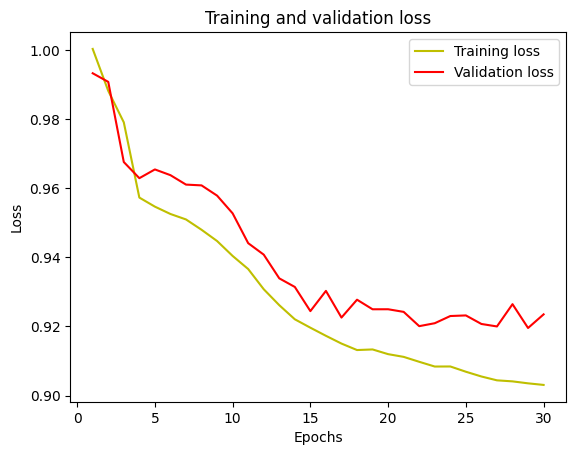

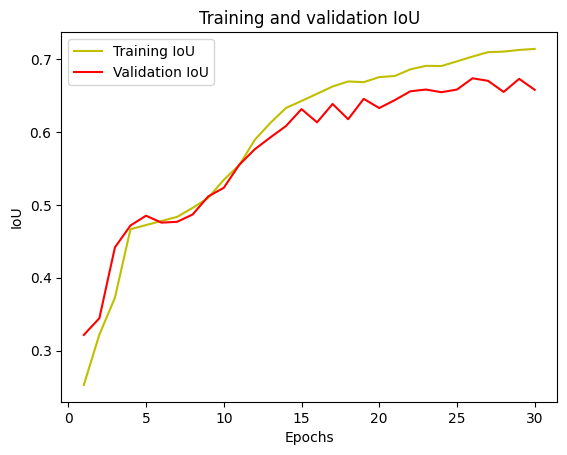

In [27]:
history = history5
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

In [31]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import custom_object_scope

# Ensure you have TensorFlow environment variable set
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Define custom loss function and metric
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# Define MRF_layer
class MRF_layer(Layer):
    def __init__(self, n_classes, **kwargs):
        self.n_classes = n_classes
        super(MRF_layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(1, 1, input_shape[-1], self.n_classes),
                                      initializer='uniform',
                                      trainable=True)
        super(MRF_layer, self).build(input_shape)

    def call(self, x):
        return K.conv2d(x, self.kernel, strides=(1, 1), padding='same')

# Define custom objects
custom_objects = {
    "dice_loss_plus_focal_loss": total_loss,  # Ensure this matches the name used during model compilation
    "jacard_coef": jacard_coef,
    "MRF_layer": MRF_layer
}


# Load the model with custom objects
with custom_object_scope(custom_objects):
    model = load_model(model_path, custom_objects=custom_objects)


9/9 [==============================] - 4s 387ms/step
Mean IoU = 0.53769857
1/1 [==============================] - 0s 55ms/step


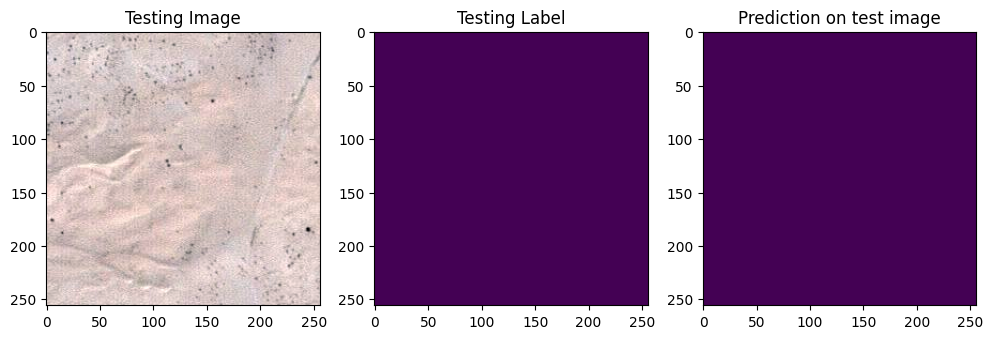

1/1 [==============================] - 0s 56ms/step


<Figure size 2000x2000 with 0 Axes>

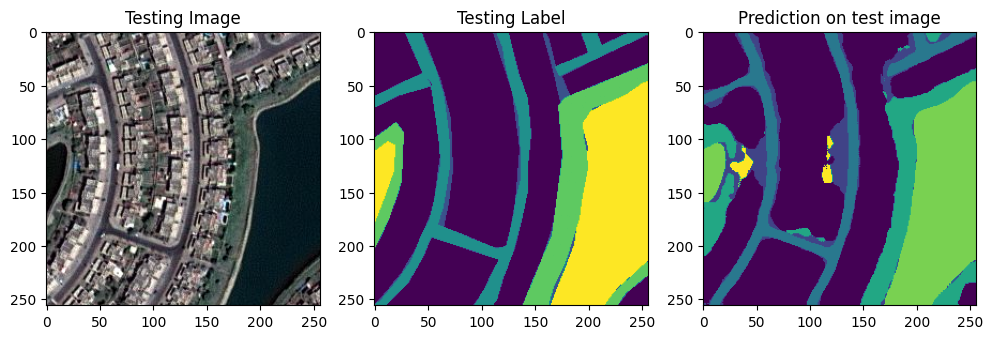

1/1 [==============================] - 0s 51ms/step


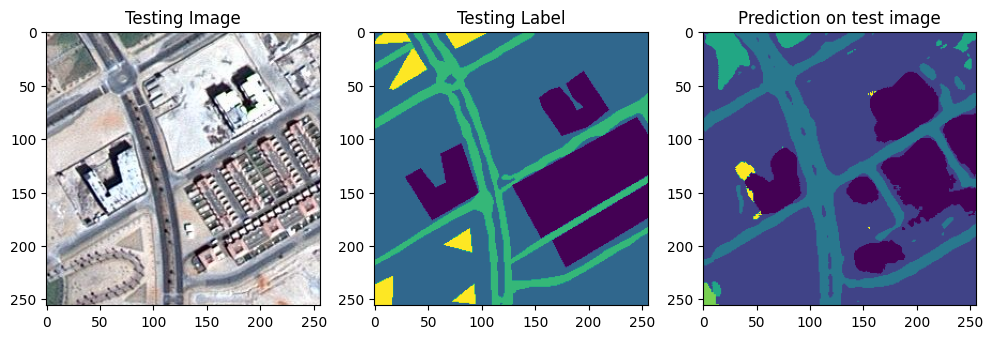

1/1 [==============================] - 0s 53ms/step


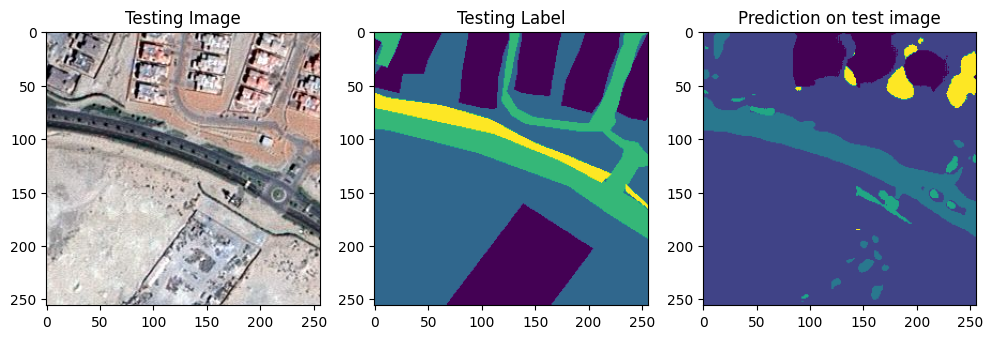

1/1 [==============================] - 0s 52ms/step


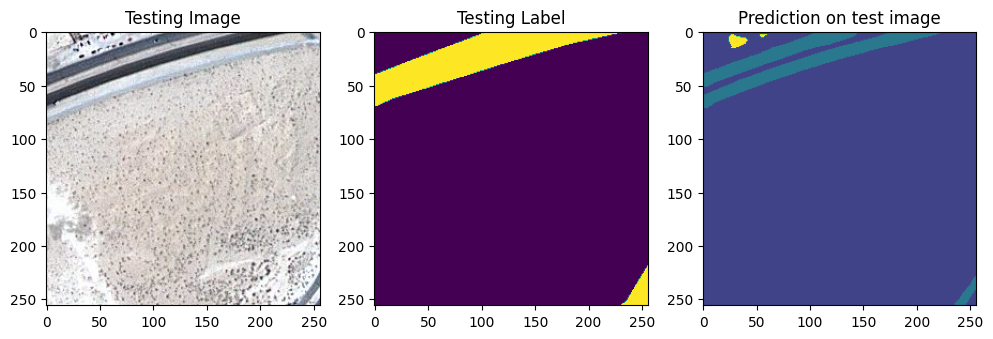

1/1 [==============================] - 0s 56ms/step


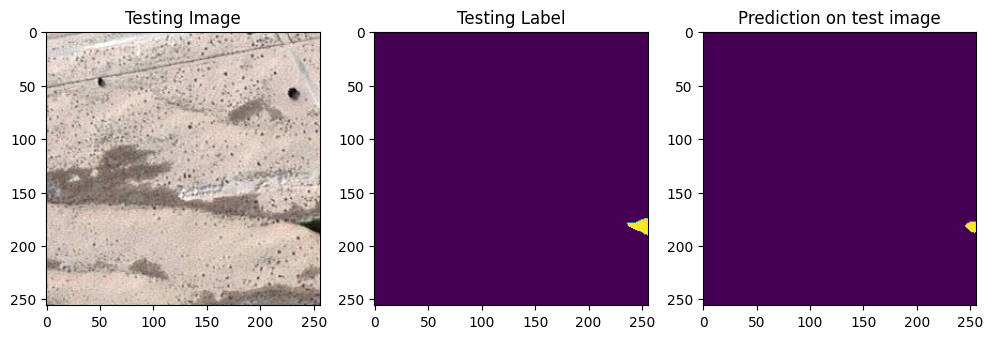

Mean IoU = 0.53769857
Dice Coefficient = 0.64896923
Precision = 0.8199694197551947
Recall = 0.8150610795879729
F1 Score = 0.8132213080617008
Pixel Accuracy = 0.8150611


In [32]:

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()
# Number of images to predict
num_images = 5

# Plot setup
plt.figure(figsize=(20, 20))

for i in range(num_images):
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img)
    plt.show()



import tensorflow as tf
from keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score

# Define number of classes
n_classes = 6

# IoU Metric
iou_keras = MeanIoU(num_classes=n_classes)
iou_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", iou_keras.result().numpy())


import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Convert to one-hot encoding if not already (assuming y_true, y_pred are integer class labels)
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)
    y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=n_classes)

    # Flatten the one-hot encoded tensors for each class
    y_true_flat = tf.reshape(y_true_one_hot, [-1, n_classes])
    y_pred_flat = tf.reshape(y_pred_one_hot, [-1, n_classes])

    # Compute Dice Coefficient per class and then average
    intersection = tf.reduce_sum(tf.cast(y_true_flat * y_pred_flat, tf.float32), axis=0)
    union = tf.reduce_sum(tf.cast(y_true_flat, tf.float32), axis=0) + tf.reduce_sum(tf.cast(y_pred_flat, tf.float32), axis=0)

    dice_per_class = (2. * intersection + smooth) / (union + smooth)
    dice_mean = tf.reduce_mean(dice_per_class)  # Average Dice coefficient across all classes

    return dice_mean

# Example usage
dice = dice_coefficient(y_test_argmax, y_pred_argmax)
print("Dice Coefficient =", dice.numpy())


# Precision and Recall
precision = precision_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted', zero_division=1)
recall = recall_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted', zero_division=1)
print("Precision =", precision)
print("Recall =", recall)

# F1 Score
f1 = f1_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted')
print("F1 Score =", f1)


import tensorflow as tf

def pixel_accuracy(y_true, y_pred):
    # Ensure both tensors are of the same type, here they're int64
    y_true = tf.cast(y_true, tf.int64)  # Make sure both are int64
    y_pred = tf.cast(y_pred, tf.int64)

    # Compute accuracy
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total = tf.size(y_true, out_type=tf.float32)  # Make sure the size is float for division
    return correct / total

# Example usage
accuracy = pixel_accuracy(y_test_argmax, y_pred_argmax)
print("Pixel Accuracy =", accuracy.numpy())




In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined and trained your model
# Make predictions
predictions = model.predict(X_test)  # Replace X_test with your actual test data

# Check original shape of predictions
print("Original predictions shape:", predictions.shape)  # Should be (number_of_samples, height, width, num_classes)

# Convert predictions to class labels
predictions = np.argmax(predictions, axis=-1)  # Shape should be (number_of_samples, height, width)

# Check the shape of labels (make sure this matches your expectations)
print("True labels shape:", labels.shape)  # This should be (number_of_samples, height, width)

# Flatten the labels and predictions
true_labels_flat = labels.flatten()  # Check this shape
pred_labels_flat = predictions.flatten()  # Ensure this is defined

# Confirm flattened shapes
print("Flattened True labels shape:", true_labels_flat.shape)
print("Flattened Predicted labels shape:", pred_labels_flat.shape)

# Compute confusion matrix
cm = confusion_matrix(true_labels_flat, pred_labels_flat, labels=np.arange(n_classes))

# Print or plot confusion matrix
print("Confusion Matrix:\n", cm)

# (Optional) Plot confusion matrix if needed
# You can use matplotlib or seaborn to visualize cm


9/9 [==============================] - 3s 373ms/step
Original predictions shape: (261, 256, 256, 6)
True labels shape: (1305, 256, 256, 1)
Flattened True labels shape: (85524480,)
Flattened Predicted labels shape: (17104896,)


ValueError: Found input variables with inconsistent numbers of samples: [85524480, 17104896]

In [60]:
%pwd

'/content'

9/9 [==============================] - 3s 369ms/step
Mean IoU = 0.53769857
1/1 [==============================] - 0s 52ms/step


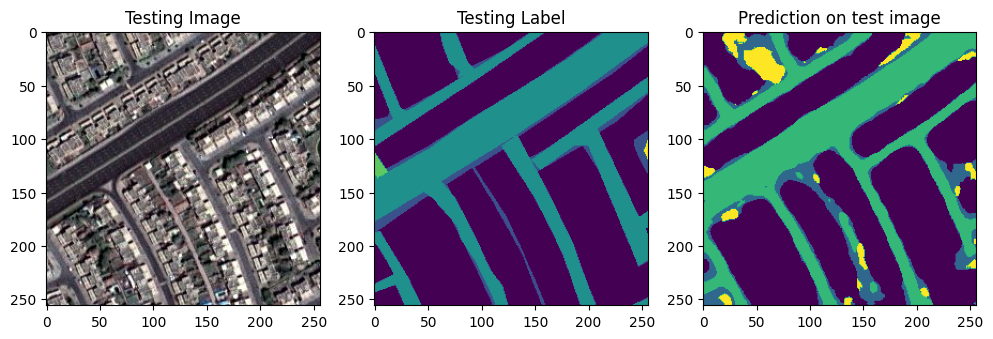

1/1 [==============================] - 0s 52ms/step


<Figure size 2000x2000 with 0 Axes>

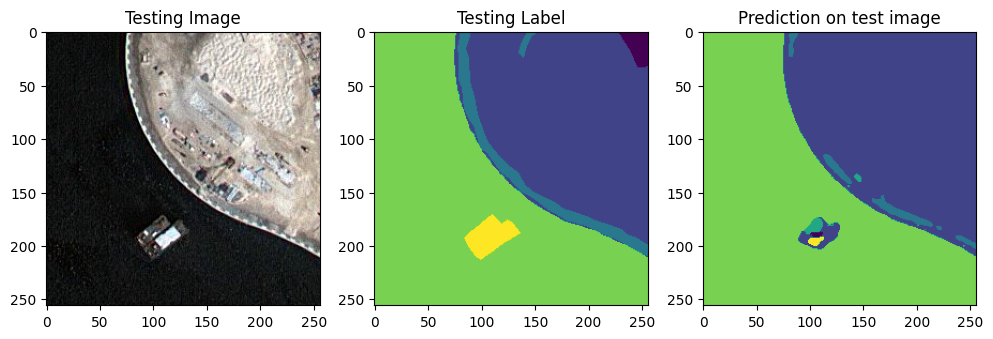

1/1 [==============================] - 0s 51ms/step


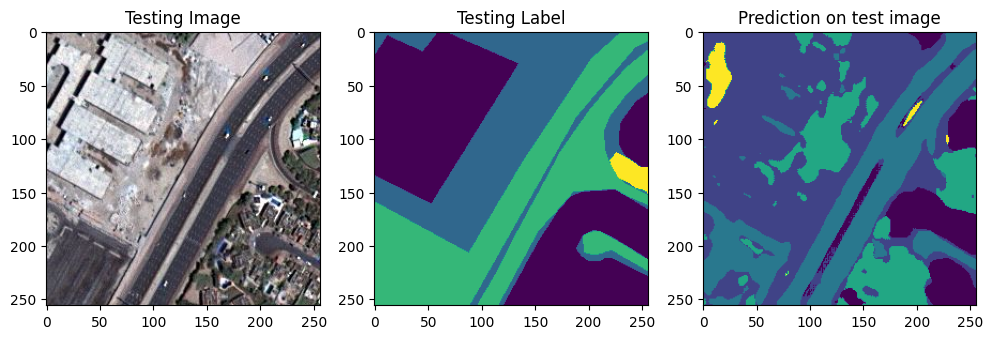

1/1 [==============================] - 0s 50ms/step


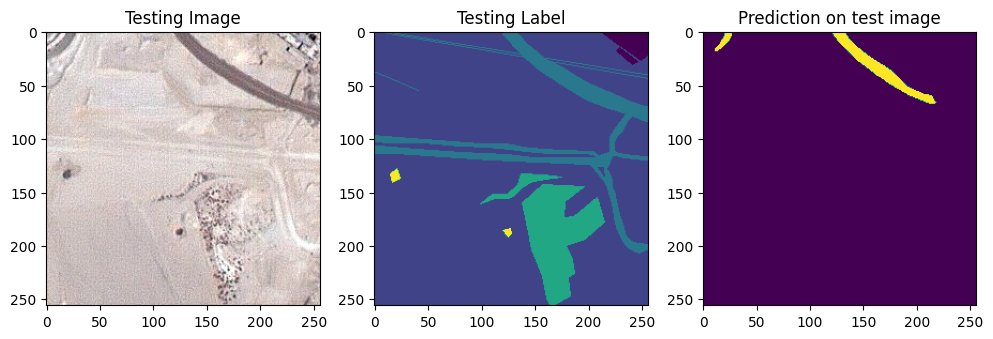

1/1 [==============================] - 0s 50ms/step


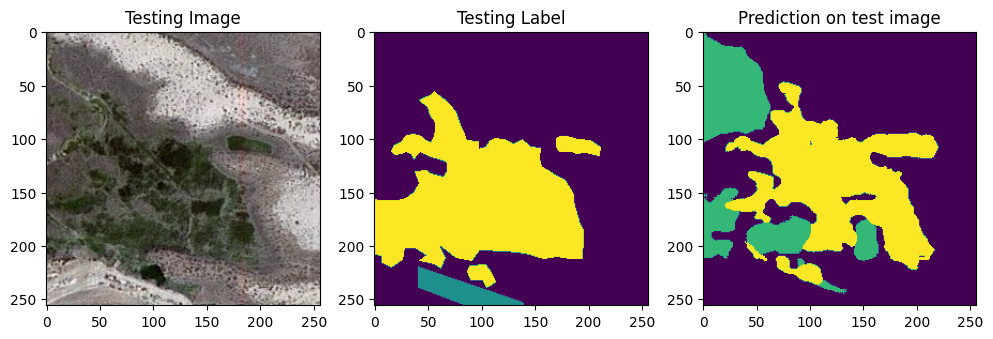

1/1 [==============================] - 0s 50ms/step


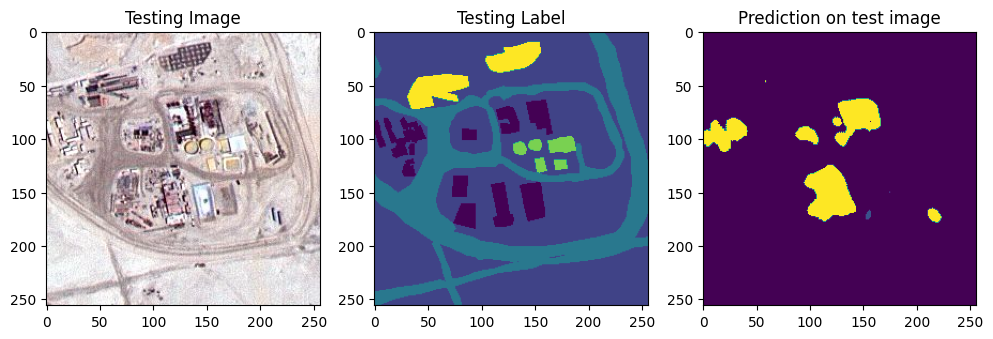

Mean IoU = 0.53769857
Dice Coefficient = 0.64896923
Precision = 0.8199694197551947
Recall = 0.8150610795879729
F1 Score = 0.8132213080617008
Pixel Accuracy = 0.8150611


In [65]:

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()
# Number of images to predict
num_images = 5

# Plot setup
plt.figure(figsize=(20, 20))

for i in range(num_images):
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img)
    plt.show()



import tensorflow as tf
from keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score

# Define number of classes
n_classes = 6

# IoU Metric
iou_keras = MeanIoU(num_classes=n_classes)
iou_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", iou_keras.result().numpy())


import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Convert to one-hot encoding if not already (assuming y_true, y_pred are integer class labels)
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)
    y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=n_classes)

    # Flatten the one-hot encoded tensors for each class
    y_true_flat = tf.reshape(y_true_one_hot, [-1, n_classes])
    y_pred_flat = tf.reshape(y_pred_one_hot, [-1, n_classes])

    # Compute Dice Coefficient per class and then average
    intersection = tf.reduce_sum(tf.cast(y_true_flat * y_pred_flat, tf.float32), axis=0)
    union = tf.reduce_sum(tf.cast(y_true_flat, tf.float32), axis=0) + tf.reduce_sum(tf.cast(y_pred_flat, tf.float32), axis=0)

    dice_per_class = (2. * intersection + smooth) / (union + smooth)
    dice_mean = tf.reduce_mean(dice_per_class)  # Average Dice coefficient across all classes

    return dice_mean

# Example usage
dice = dice_coefficient(y_test_argmax, y_pred_argmax)
print("Dice Coefficient =", dice.numpy())


# Precision and Recall
precision = precision_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted', zero_division=1)
recall = recall_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted', zero_division=1)
print("Precision =", precision)
print("Recall =", recall)

# F1 Score
f1 = f1_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted')
print("F1 Score =", f1)


import tensorflow as tf

def pixel_accuracy(y_true, y_pred):
    # Ensure both tensors are of the same type, here they're int64
    y_true = tf.cast(y_true, tf.int64)  # Make sure both are int64
    y_pred = tf.cast(y_pred, tf.int64)

    # Compute accuracy
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total = tf.size(y_true, out_type=tf.float32)  # Make sure the size is float for division
    return correct / total

# Example usage
accuracy = pixel_accuracy(y_test_argmax, y_pred_argmax)
print("Pixel Accuracy =", accuracy.numpy())


